Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import *


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Creating a dataset



In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
# Says 6739 files since more have been added
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train , batch_size=batch_size , image_size = (img_height , img_width) , seed=123 , validation_split=0.2 , subset='training' )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test , batch_size=batch_size , image_size = (img_height , img_width) , seed=123 , validation_split=0.2 , subset = 'validation' )

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [ ]:
# These correspond to the directory names in alphabetical order.
class_names = ['actinic keratosis' , 'basal cell carcinoma' , 'dermatofibroma' , 'melanoma' , 'nevus' , 'pigmented benign keratosis' , 'seborrheic keratosis' , 'squamous cell carcinoma' , 'vascular lesion']
class_names = train_ds.class_names
print(class_names)

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']


### Visualize the data
#### creating a code to visualize one instance of all the nine classes present in the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


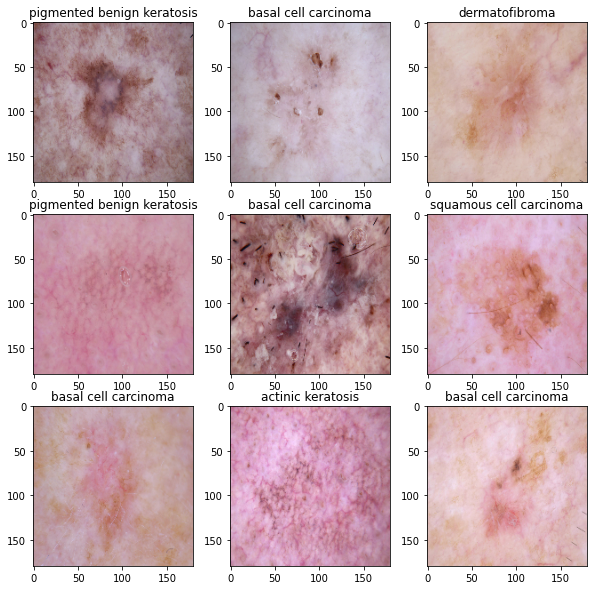

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(20):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
### Your code goes here
rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
train_ds= train_ds.map(
  lambda x, y: (rescale(x, training=True), y))

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Adding 32 filters to begin with , Kernel Size of (3,3) which would make computation simple, then adding another filter of 128. Some pooling and dropout has also been added to avoid overfitting. Maxpooling is used because there is clearly a patch that carries more weightage. Dropout has not been added**

In [ ]:
model = Sequential()
model.add(Conv2D(32 , kernel_size = (3,3) , activation = 'relu' , input_shape = (180, 180, 3) , padding='same'))
model.add(Conv2D(128 , (3,3) , activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64 , kernel_size = (3,3) , activation = 'relu' , padding='same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128 , (3,3) , activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64 , (3,3) , activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 178, 178, 128)     36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 89, 89, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 128)     

* Optimizer chosen is ADAM since it combines good properties from two popular optimisers; adagrand and adadelta. These are good options since the learning rate of parameters must be sufficiently penalised since we are detecting cancer. We need to minimize the errors as much as possible*

### Compiling the model


In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 128)     36992     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 89, 89, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 89, 89, 64)        73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 44, 44, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 44, 44, 64)       

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = 32
)

Epoch 1/20
56/56 [==============================] - 362s 231ms/step - loss: 2.1271 - accuracy: 0.1854 - val_loss: 42.5088 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 6s 112ms/step - loss: 2.0585 - accuracy: 0.1775 - val_loss: 25.9894 - val_accuracy: 0.0435
Epoch 3/20
56/56 [==============================] - 6s 112ms/step - loss: 1.9907 - accuracy: 0.2400 - val_loss: 40.9303 - val_accuracy: 0.1304
Epoch 4/20
56/56 [==============================] - 6s 112ms/step - loss: 1.8799 - accuracy: 0.3257 - val_loss: 20.7300 - val_accuracy: 0.2174
Epoch 5/20
56/56 [==============================] - 6s 113ms/step - loss: 1.8767 - accuracy: 0.2939 - val_loss: 17.9968 - val_accuracy: 0.0870
Epoch 6/20
56/56 [==============================] - 6s 113ms/step - loss: 1.7456 - accuracy: 0.3710 - val_loss: 159.1634 - val_accuracy: 0.0435
Epoch 7/20
56/56 [==============================] - 6s 113ms/step - loss: 1.6932 - accuracy: 0.3818 - val_loss: 73.0336 - val_accuracy: 0.1

### Visualizing training results

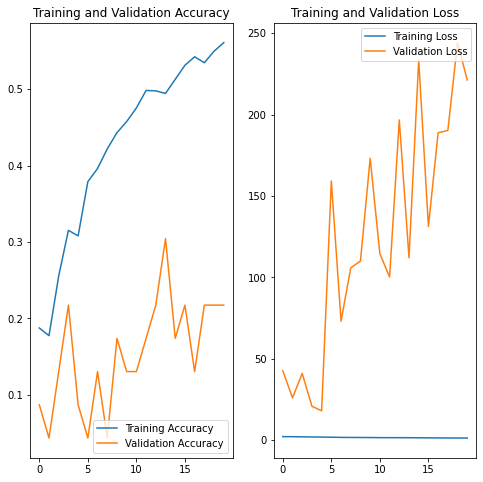

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### It can be seen that the training accuracy is nearing 0.6 but but validation accuracy, a mere 0.2. This is a case of overfitting

### Let us try some data augmentation strategies like tilting images, zooming in etc. Also, adding some more layers and normalisation may make a difference.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train , batch_size=batch_size , image_size = (img_height , img_width) , seed=123 , validation_split=0.2 , subset = 'validation' )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test , batch_size=batch_size , image_size = (img_height , img_width) , seed=123 , validation_split=0.2 , subset = 'validation' )
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.
Using 23 files for validation.


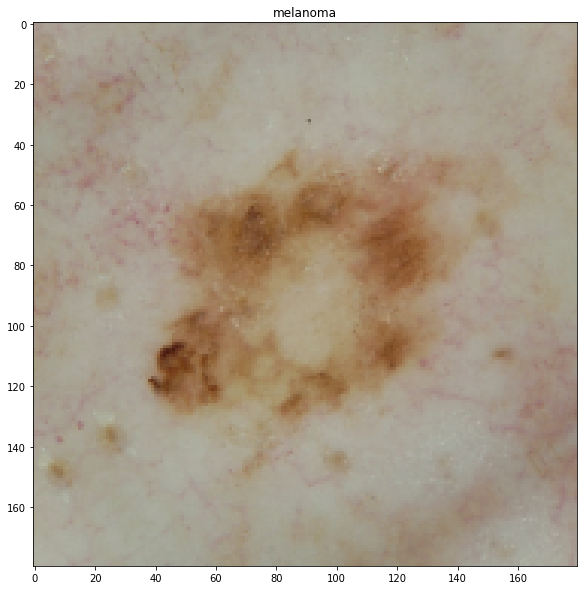

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in aug_ds.take(2):
  for i in range(5):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

In [ ]:
rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
aug_ds= aug_ds.map(
  lambda x, y: (rescale(x, training=True), y))

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2


### Creating the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential()
model.add(Conv2D(32 , kernel_size = (3,3) , activation = 'relu' , input_shape = (180, 180, 3) , padding='same'))
model.add(Conv2D(128 , (3,3) , activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(9))
model.add(Activation('softmax'))



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 178, 178, 128)     36992     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 89, 89, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 89, 89, 64)        73792     
_________________________________________________________________
activation_9 (Activation)    (None, 89, 89, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 89, 89, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 87, 87, 64)      

### Training the model

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = 50
)

Epoch 1/25
14/14 [==============================] - 2s 158ms/step - loss: 1.7867 - accuracy: 0.8613 - val_loss: 16.4799 - val_accuracy: 0.0435
Epoch 2/25
14/14 [==============================] - 2s 157ms/step - loss: 1.8169 - accuracy: 0.8926 - val_loss: 18.0236 - val_accuracy: 0.0000e+00
Epoch 3/25
14/14 [==============================] - 2s 157ms/step - loss: 1.7681 - accuracy: 0.8881 - val_loss: 16.1364 - val_accuracy: 0.0435
Epoch 4/25
14/14 [==============================] - 2s 158ms/step - loss: 1.7262 - accuracy: 0.8725 - val_loss: 8.7444 - val_accuracy: 0.1739
Epoch 5/25
14/14 [==============================] - 2s 157ms/step - loss: 1.7932 - accuracy: 0.8635 - val_loss: 12.2601 - val_accuracy: 0.1304
Epoch 6/25
14/14 [==============================] - 2s 157ms/step - loss: 2.0948 - accuracy: 0.8345 - val_loss: 25.4698 - val_accuracy: 0.0435
Epoch 7/25
14/14 [==============================] - 2s 158ms/step - loss: 2.2252 - accuracy: 0.8613 - val_loss: 22.9322 - val_accuracy: 0.1

### Visualizing the results

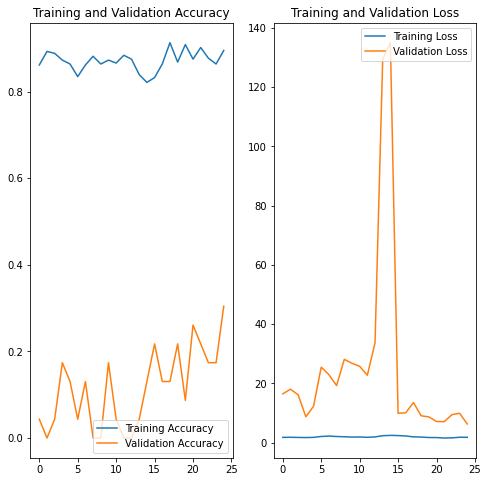

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### There is still overfitting. The training accuracy is as high as 90 and validation accuracy only nearing 0.4

#### Finding the distribution of classes in the training dataset.

In [ ]:
import os
file_names = ['actinic keratosis' , 'basal cell carcinoma' , 'dermatofibroma' , 'melanoma' , 'nevus' , 'pigmented benign keratosis' , 'seborrheic keratosis' , 'squamous cell carcinoma' , 'vascular lesion']

for i in file_names:
  list3 = os.listdir("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"+i) # dir is your directory path
  number_files = len(list3)
  print (i + ': ' + str(number_files))

actinic keratosis: 115
basal cell carcinoma: 377
dermatofibroma: 96
melanoma: 439
nevus: 358
pigmented benign keratosis: 463
seborrheic keratosis: 78
squamous cell carcinoma: 182
vascular lesion: 140


#### seborrheic keratosis has the least number of samples
#### pigmented benign keratosis , melanoma, basal cell carcinoma dominate the data in terms proportionate number of samples


#### Rectifying the class imbalance
#### 

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset= "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32E818BFD0>: 100%|██████████| 500/500 [00:18<00:00, 27.31 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32FBF2FD50>: 100%|██████████| 500/500 [00:18<00:00, 27.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32EE082610>:   0%|          | 1/500 [00:00<01:17,  6.47 Samples/s]                  

Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F336992DA90>: 100%|██████████| 500/500 [00:18<00:00, 27.00 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F32F01FBB50>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7F3362F20550>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32FA444B50>: 100%|██████████| 500/500 [00:18<00:00, 26.80 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F32FA5210D0>: 100%|██████████| 500/500 [00:40<00:00, 12.32 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F32EE6BDE90>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F32EE428C50>: 100%|██████████| 500/500 [00:18<00:00, 27.12 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F32EE6C5290>: 100%|██████████| 500/500 [00:19<00:00, 26.20 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
for i in file_names:
  list1 = os.listdir("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"+i) # dir is your directory path
  list2 = os.listdir("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"+i+'/'+'output')
  number_files = len(list1)+len(list2)
  print (i + ': ' + str(number_files))


actinic keratosis: 615
basal cell carcinoma: 877
dermatofibroma: 596
melanoma: 939
nevus: 858
pigmented benign keratosis: 963
seborrheic keratosis: 578
squamous cell carcinoma: 682
vascular lesion: 640


In [ ]:
del list
image_count_train = len(list (data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
from glob import *
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028323.jpg_b97197a3-b123-4179-9da1-81b492a5bd37.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028652.jpg_3277edc6-84b5-4b5d-9f92-829f88766d5e.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028570.jpg_f5a4856d-8d32-40e7-b5a4-3f01182bf862.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030746.jpg_7ad339bf-96a7-4435-b331-55d488088be5.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collabor

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

NameError: ignored

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test",
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
aug_ds= aug_ds.map(
  lambda x, y: (rescale(x, training=True), y))

####  Creating a model 

In [ ]:
model = Sequential()
model.add(Conv2D(64 , kernel_size = (3,3) , activation = 'relu' , input_shape = (180, 180, 3) , padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

#### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Training the model

In [ ]:
epochs = 50
history = model.fit(
  aug_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = 128
)

Epoch 1/50
169/169 [==============================] - 31s 179ms/step - loss: 14.7750 - accuracy: 0.2619 - val_loss: 344.0715 - val_accuracy: 0.0435
Epoch 2/50
169/169 [==============================] - 31s 181ms/step - loss: 6.8145 - accuracy: 0.3631 - val_loss: 265.6150 - val_accuracy: 0.0435
Epoch 3/50
169/169 [==============================] - 31s 182ms/step - loss: 4.0476 - accuracy: 0.3828 - val_loss: 626.6218 - val_accuracy: 0.0435
Epoch 4/50
169/169 [==============================] - 31s 181ms/step - loss: 2.8774 - accuracy: 0.4106 - val_loss: 1557.8219 - val_accuracy: 0.0435
Epoch 5/50
169/169 [==============================] - 31s 181ms/step - loss: 2.4934 - accuracy: 0.4083 - val_loss: 989.1461 - val_accuracy: 0.0000e+00
Epoch 6/50
169/169 [==============================] - 30s 178ms/step - loss: 2.3503 - accuracy: 0.4174 - val_loss: 1059.8093 - val_accuracy: 0.0435
Epoch 7/50
169/169 [==============================] - 30s 179ms/step - loss: 2.0430 - accuracy: 0.4636 - val_lo

#### Visualizing the model results

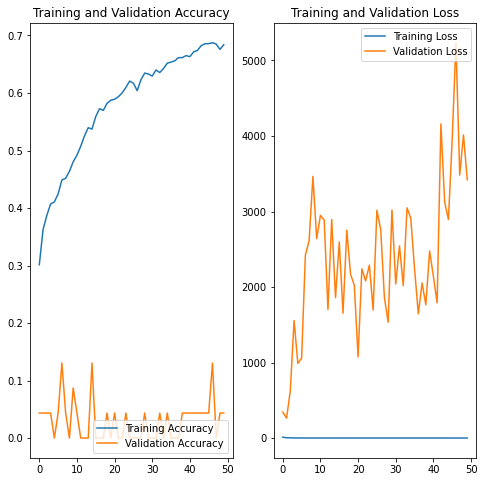

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**** It can be seen that the training accuracy is pretty low and the validation accuracy is significantly lower. There may be some overfitting. Let us see how the model works on the datadet in which augmentation hasn't taken place ****

#### Analyzing results here. 



In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = 128
)

Epoch 1/50
169/169 [==============================] - 9s 51ms/step - loss: 1.6550 - accuracy: 0.7073 - val_loss: 3.5272 - val_accuracy: 0.3478
Epoch 2/50
169/169 [==============================] - 9s 51ms/step - loss: 1.5083 - accuracy: 0.7570 - val_loss: 4.8506 - val_accuracy: 0.3043
Epoch 3/50
169/169 [==============================] - 9s 51ms/step - loss: 1.5217 - accuracy: 0.7674 - val_loss: 4.1595 - val_accuracy: 0.3478
Epoch 4/50
169/169 [==============================] - 9s 51ms/step - loss: 1.4905 - accuracy: 0.7875 - val_loss: 4.9919 - val_accuracy: 0.3043
Epoch 5/50
169/169 [==============================] - 9s 50ms/step - loss: 1.5438 - accuracy: 0.7828 - val_loss: 4.5239 - val_accuracy: 0.2609
Epoch 6/50
169/169 [==============================] - 9s 50ms/step - loss: 1.5074 - accuracy: 0.7990 - val_loss: 4.5527 - val_accuracy: 0.2609
Epoch 7/50
169/169 [==============================] - 9s 50ms/step - loss: 1.5191 - accuracy: 0.8068 - val_loss: 3.9762 - val_accuracy: 0.3043

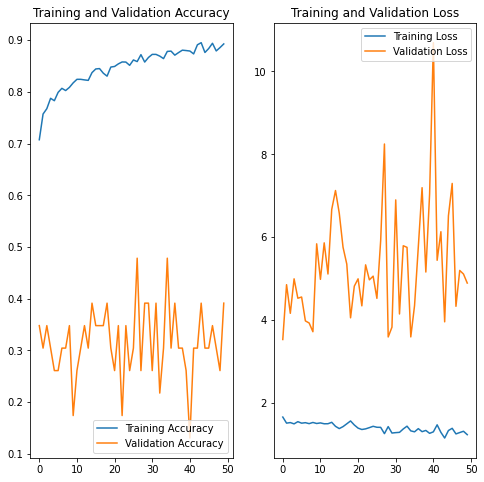

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy is almost 0.9 on the training dataset (on ignoring the augmented dataset) , though the validation accuracy is better when compared to the previous execution, it is still pretty low. The overfitting is not resolved